In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
from tensorflow import  keras
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler,StandardScaler,scale
from skimage.measure import block_reduce
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout

In [2]:
def load_data():
    als = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/ALS.mat',)["data"].transpose()  #(262134, 321)
    normal = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/normal.mat')['data'].transpose() # (262134, 270) 
    myopathy = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/myopathie.mat')['data'].transpose() #(262134, 315)
    return als,normal,myopathy

In [3]:

def scale_data_minmax(data):
#type of scaler that scales the minimum and maximum values to be 0 and 1 respectively. 
    scaler = MinMaxScaler()
#fit_transform() then it will calculate the mean(μ) and standard deviation(σ) of the feature F at a time it will transform the data points of the feature F.    
    normalized_data =scaler.fit_transform(data)


    return normalized_data

In [4]:
def scale_data_standard(data):
    scaled_data = scale(data,axis=1)
    return scaled_data

In [5]:
def gen_tensors_list(data,dim):
    dataset  = list()
    for i in range (len(data)):
        arg = tf.convert_to_tensor(data[i], dtype=tf.float32)
        arg = tf.reshape(arg,dim)
        dataset.append(arg)

    return dataset

In [6]:
def windowing_fun(data,window_size=1000,overlap=100):
    windowed_data = [data[j][i : i + window_size] for j in range(0,len(data)) for i in range(0, len(data[j]), window_size-overlap)]
    final_data = [windowed_data[i] for i in range(len(windowed_data)) if len(windowed_data[i]) == window_size ]
    return final_data

In [7]:
def load_file_names():
    als = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/ALS.mat',)["files"]  #(262134, 321)
    normal = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/normal.mat')['files'] # (262134, 270) 
    myopathy = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/myopathie.mat')['files'] #(262134, 315)
    return als,normal,myopathy

In [8]:
def generate_dataframe(data,files):
    df = pd.DataFrame([], columns=['type_signal',"num_personne","muscle","num_enregistrement","signal"])
    windowed_data = [{"signal": data[j],"type_signal":files[0][j][0][5],"num_personne": files[0][j][0][6:8],"muscle": files[0][j][0][8:10],"num_enregistrement":files[0][j][0][10:12] } for j in range(0,len(data)) ]
    final_data = pd.DataFrame(windowed_data)
    #df =df.append(final_data, ignore_index=True)
    #df =pd.concat([df, final_data])
    df = pd.concat([df, final_data], ignore_index=True)
    return df

In [26]:
als, normal , myopathy = load_data()

In [27]:
alsfiles,normalfiles,myopathyfiles = load_file_names()

In [28]:
df = generate_dataframe(np.vstack((normal,als,myopathy)),np.concatenate((normalfiles,alsfiles,myopathyfiles),axis=1))

In [29]:
def f(row):
    return {"C":0,"A":1,"M":2}[row["type_signal"]]

df["num_class"] =df.apply(f, axis=1) 

In [30]:
df = df.query("muscle=='BB'")

In [31]:
X = df['signal'].tolist()
Y = df['num_class'].tolist()

In [32]:
X=X[170:]
Y=Y[170:]

In [33]:
del df

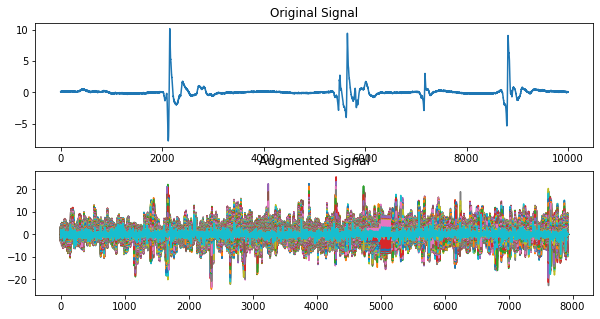

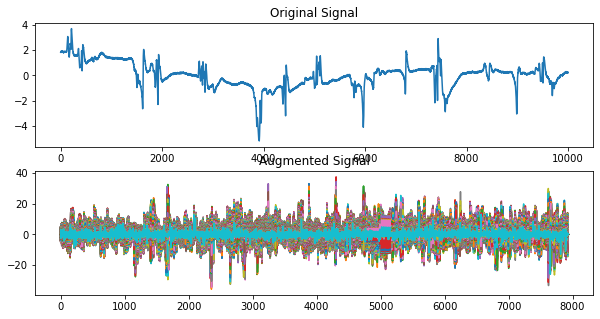

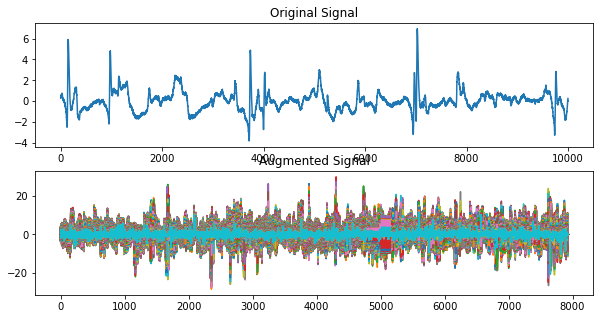

In [67]:
##SCALING
# Select a few random samples from your dataset
samples = random.sample(list(X), k=3)

# Plot the original and augmented signals
for sample in samples:
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].plot(sample)
    axs[0].set_title('Original Signal')
    
    # Apply augmentation techniques
    X = np.array(X)
    scale_factor = np.random.uniform(0.8, 1.2)
    augmented_sample = X * scale_factor
    
    axs[1].plot(augmented_sample)
    axs[1].set_title('Augmented Signal')
    
    plt.show()


In [34]:
#data augmentation using scaling
X = np.array(X)
scale_factor = np.random.uniform(0.8, 1.2)
X_scaled = X * scale_factor

np.shape(X_scaled)

(305, 262134)

In [35]:
augmented_X_df = pd.DataFrame(X_scaled)
scaled_data = pd.concat([pd.DataFrame(X), augmented_X_df])
data = [*augmented_X_df]
np.shape(data)

(262134,)

In [36]:
data = np.concatenate((X_scaled, X))
np.shape(data)

(610, 262134)

In [37]:
del  als,normal,myopathy,alsfiles,normalfiles,myopathyfiles 

In [38]:
data = scale_data_standard(data)

In [39]:
count_normal = Y.count(0)
last_index_normal = count_normal * 2 - 1
last_index_normal

199

In [40]:
count_als = Y.count(1)
last_index_als = last_index_normal + count_als * 2
last_index_als

395

In [41]:
count_myopathy = Y.count(2)
last_index_myopathy = last_index_als + count_myopathy * 2
last_index_myopathy

609

In [42]:
windowed_normal = len(windowing_fun(X[:last_index_normal+1],10000))
windowed_als = len(windowing_fun(X[last_index_normal+1:last_index_als+1],10000))
windowed_myopathy = len(windowing_fun(X[last_index_als+1:],10000))

In [43]:
Y = [0]*(windowed_normal)+[1]*(windowed_als)+[2]*(windowed_myopathy)
np.shape(Y)

(7930,)

In [44]:
X = windowing_fun(data,10000)

In [45]:
del data

In [49]:
X = scale_data_standard(X)

In [50]:
tensors_list = gen_tensors_list(X,(1,10000))

In [51]:
print("1",len(tensors_list))
print("2",len(Y))

Y = Y * 2
print("3",len(Y))

1 15860
2 7930
3 15860


In [52]:
#X_train, X_test, y_train, y_test = train_test_split( tensors_list, Y, test_size=0.04,random_state=20)
X_train, X_val, y_train, y_val = train_test_split(tensors_list, Y, test_size=0.2, random_state=42)
np.shape(X_train), np.shape(X_val)

((12688, 1, 10000), (3172, 1, 10000))

In [58]:
model = Sequential([
    #Conv2D(#of filters, filters size, activation function)
    #in keras for the first layer we always need to mention the input shape
    Conv1D(64, 5, activation = 'relu', padding ="same", input_shape = (1,10000)), 
    
    #MaxPooling2D(filter size stride and pad can also be added)
    MaxPooling1D(2, strides = 3, padding ="same"),
    
    #LAYER2
    Conv1D(32, 5, activation = 'relu', padding ="same"), #inc filter size and stride
    MaxPooling1D(2, strides = 3, padding ="same"),
    
    #FLATTEN
    Flatten(),
    
    #FC Layers:
    
    #LAYER3
    #Dense : fully connected  Dense(#neurons, activation function )
    Dense(64, activation = 'relu'),
    Dropout(0.6),
    
    #LAYER4
    Dense(3, activation = 'softmax'),
    
    
])


In [59]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [60]:
#model.fit(X_train, y_train, epochs =20, batch_size = 128)

Epoch 1/15
100/100 [==============================] - 39s 372ms/step - loss: 0.7593 - accuracy: 0.6125 - val_loss: 0.5835 - val_accuracy: 0.6778
Epoch 2/15
100/100 [==============================] - 38s 375ms/step - loss: 0.5599 - accuracy: 0.7148 - val_loss: 0.5076 - val_accuracy: 0.7472
Epoch 3/15
100/100 [==============================] - 33s 325ms/step - loss: 0.4238 - accuracy: 0.8126 - val_loss: 0.4677 - val_accuracy: 0.7904
Epoch 4/15
100/100 [==============================] - 32s 324ms/step - loss: 0.3053 - accuracy: 0.8756 - val_loss: 0.3919 - val_accuracy: 0.8427
Epoch 5/15
100/100 [==============================] - 35s 348ms/step - loss: 0.2122 - accuracy: 0.9224 - val_loss: 0.3795 - val_accuracy: 0.8666
Epoch 6/15
100/100 [==============================] - 31s 312ms/step - loss: 0.1452 - accuracy: 0.9471 - val_loss: 0.3774 - val_accuracy: 0.8859
Epoch 7/15
100/100 [==============================] - 32s 315ms/step - loss: 0.1086 - accuracy: 0.9615 - val_loss: 0.3718 - val_ac

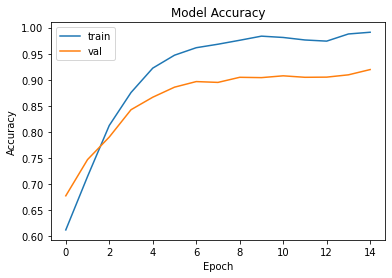

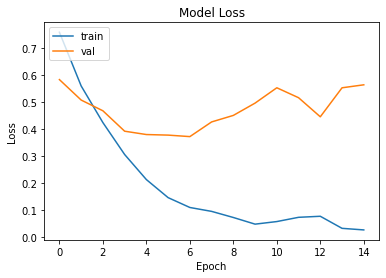

In [61]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
history = model.fit(
                    X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    validation_split=0.1,
                    epochs=15, 
                    batch_size=128)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [62]:
score = model.evaluate(np.asarray(X_val),np.asarray (y_val))

100/100 [==============================] - 1s 8ms/step - loss: 0.5641 - accuracy: 0.9196


In [59]:
model.save("/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D.h5")

In [60]:
import json

with open('/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D_score.json', 'w+') as file:

    json.dump(score, file)

In [61]:
model= tf.keras.models.load_model("/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D.h5")

In [62]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True
    )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [63]:
y_pred = model.predict(np.asarray(X_test))

40/40 [==============================] - 0s 4ms/step


In [64]:
y_predicted_labels = [{0:"Normal",1:"Neuropathie",2:"Myopathy"}[i] for i in np.argmax(y_pred,axis=1)]

In [65]:
y_true_labels = [{0:"Normal",1:"Neuropathie",2:"Myopathy"}[i] for i in y_test]